# August 21 Testing Notebook

#### Goals
In this notebook, our goal is to:

- Explore the aggregated data for Fresno and Kern that was created by Mario
- use the data in LSTM model
- use the data in Transformer model

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import torch
import torch.optim as optim 
import torch.nn as nn
import sys 
import os 

sys.path.append(os.path.abspath('..'))

from torch.utils.data import TensorDataset, DataLoader
from models import LSTM, TransformerModel
from loss_functions import RMSELoss
from trainer_new import TrainerNewNew

Importing the Data

In [2]:
fresno_data = pd.read_csv("../../data/Fresno_Aggregate.csv")

In [3]:
fresno_data

,Year-Month,VFRate,FIRE_Acres_Burned,PRECIP,WIND_EventCount,WIND_AvgMPH,WIND_RunMiles,AQI_PM25,AQI_PM10,EARTHQUAKE_Total,PESTICIDE_Total
0,2008-10,6.156349,163.91,0.18,0.0,3.667742,87.825806,70.0,53.0,0,23.056051
1,2008-11,3.407979,17.30,1.49,0.0,3.106667,74.490000,95.5,38.5,0,0.519323
2,2008-12,6.486154,0.00,1.19,0.0,3.306452,79.312903,94.0,18.5,0,0.000000
3,2009-01,6.619800,1.00,1.25,0.0,2.587097,62.019355,102.0,33.0,0,24.630400
4,2009-02,5.751629,28.00,2.33,0.0,3.928571,94.096429,51.5,13.0,0,71.542885
...,...,...,...,...,...,...,...,...,...,...,...
82,2015-08,2.569621,28.06,0.00,0.0,4.900000,117.664516,63.0,44.0,0,737.718551
83,2015-09,2.775191,210.76,0.06,0.0,4.046667,97.216667,62.0,52.0,0,544.970947
84,2015-10,5.344812,16.99,0.41,0.0,3.503226,84.058065,63.0,38.0,0,181.244457
85,2015-11,2.569621,30.46,2.13,0.0,3.116667,74.736667,75.0,26.5,0,263.108466


In [4]:
f_data = fresno_data.copy()

In [5]:
f_data["Year-Month"] = pd.to_datetime(f_data["Year-Month"])
f_data = f_data.set_index('Year-Month')
f_data

,VFRate,FIRE_Acres_Burned,PRECIP,WIND_EventCount,WIND_AvgMPH,WIND_RunMiles,AQI_PM25,AQI_PM10,EARTHQUAKE_Total,PESTICIDE_Total
Year-Month,,,,,,,,,,
2008-10-01,6.156349,163.91,0.18,0.0,3.667742,87.825806,70.0,53.0,0,23.056051
2008-11-01,3.407979,17.30,1.49,0.0,3.106667,74.490000,95.5,38.5,0,0.519323
2008-12-01,6.486154,0.00,1.19,0.0,3.306452,79.312903,94.0,18.5,0,0.000000
2009-01-01,6.619800,1.00,1.25,0.0,2.587097,62.019355,102.0,33.0,0,24.630400
2009-02-01,5.751629,28.00,2.33,0.0,3.928571,94.096429,51.5,13.0,0,71.542885
...,...,...,...,...,...,...,...,...,...,...
2015-08-01,2.569621,28.06,0.00,0.0,4.900000,117.664516,63.0,44.0,0,737.718551
2015-09-01,2.775191,210.76,0.06,0.0,4.046667,97.216667,62.0,52.0,0,544.970947
2015-10-01,5.344812,16.99,0.41,0.0,3.503226,84.058065,63.0,38.0,0,181.244457


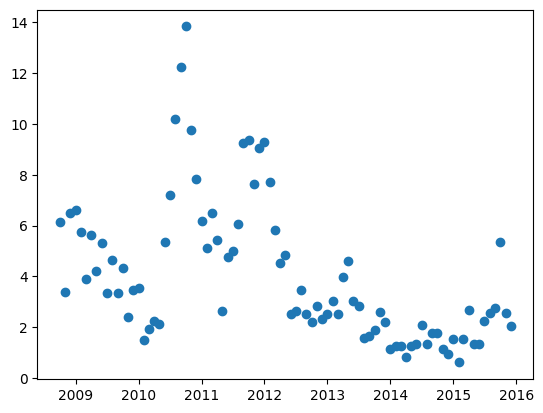

In [6]:
plt.scatter(f_data.index, f_data["VFRate"])
plt.show()

## Experiment 1: Taking all predictors (besides VFRate)

In [7]:
f_data.columns

Index(['VFRate', 'FIRE_Acres_Burned', 'PRECIP', 'WIND_EventCount',
       'WIND_AvgMPH', 'WIND_RunMiles', 'AQI_PM25', 'AQI_PM10',
       'EARTHQUAKE_Total', 'PESTICIDE_Total'],
      dtype='object')

In [8]:
target_cols = ["FIRE_Acres_Burned", "PRECIP", "WIND_EventCount", "WIND_AvgMPH", 
               "WIND_RunMiles", "AQI_PM25", "AQI_PM10", "EARTHQUAKE_Total", "PESTICIDE_Total"]
X = f_data[target_cols]
y = f_data["VFRate"]

In [9]:
X.head()

,FIRE_Acres_Burned,PRECIP,WIND_EventCount,WIND_AvgMPH,WIND_RunMiles,AQI_PM25,AQI_PM10,EARTHQUAKE_Total,PESTICIDE_Total
Year-Month,,,,,,,,,
2008-10-01,163.91,0.18,0.0,3.667742,87.825806,70.0,53.0,0,23.056051
2008-11-01,17.30,1.49,0.0,3.106667,74.490000,95.5,38.5,0,0.519323
2008-12-01,0.00,1.19,0.0,3.306452,79.312903,94.0,18.5,0,0.000000
2009-01-01,1.00,1.25,0.0,2.587097,62.019355,102.0,33.0,0,24.630400
2009-02-01,28.00,2.33,0.0,3.928571,94.096429,51.5,13.0,0,71.542885


In [10]:
y.head()

Year-Month
2008-10-01    6.156349
2008-11-01    3.407979
2008-12-01    6.486154
2009-01-01    6.619800
2009-02-01    5.751629
Name: VFRate, dtype: float64

In [11]:
# helper functions

def create_sequences(X, y, seq_length):
  Xs, ys = [], [] 
  for idx in range(len(X) - seq_length):
    Xs.append(X[idx:idx+seq_length])
    ys.append(y[idx+seq_length])
  return np.array(Xs), np.array(ys)


## Autocorrelation Test for VFRate to see if 12 month is valid to use

<function matplotlib.pyplot.show(close=None, block=None)>

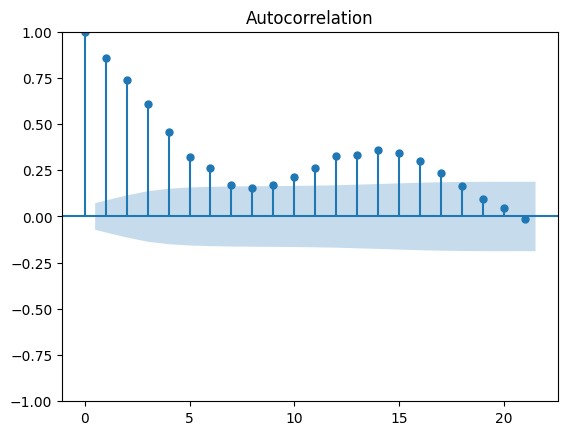

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

lags_to_check = 87//4 
plot_acf(y, lags=lags_to_check, alpha=0.5)
plt.show


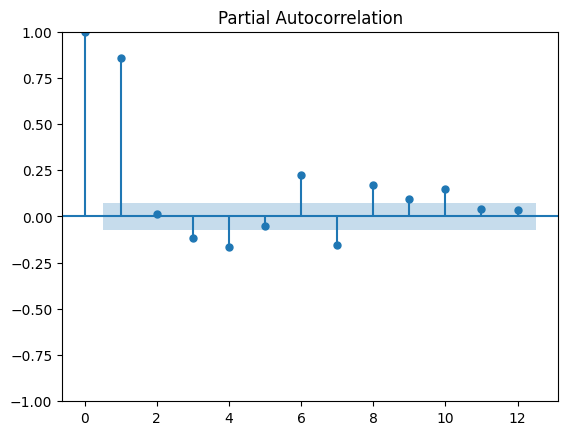

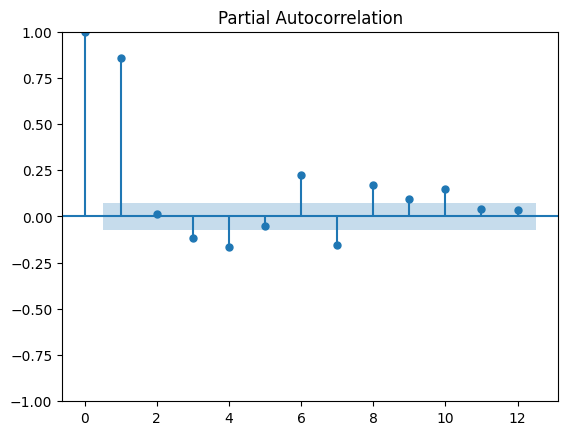

In [13]:
l1 = 12
l2 = 87//4

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(y, lags=l1, alpha=0.5)

Since Valley Fever is not communicable, looking at autocorrelation, lag, and even including it in the feature vector probably isn't useful. So I will keep it out and just keep the VFRate value in its target vector form, as is.

In [14]:
# train/test split
seq_length = 12
features, target = create_sequences(X, y, seq_length=seq_length)

/var/folders/t9/31hxp9pj31j5vk49l32mdc500000gn/T/ipykernel_1502/404682972.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[idx+seq_length])


In [15]:
print(features.shape, target.shape)

(75, 12, 9) (75,)


In [16]:
# convert into tensors
features = torch.tensor(features, dtype=torch.float32)
target   = torch.tensor(target, dtype=torch.float32)

In [17]:
# Train/Test split
split_frac = 0.75
split_idx = int(len(features)*split_frac)
X_train, X_test = features[:split_idx], features[split_idx:]
y_train, y_test = target[:split_idx], target[split_idx:]

In [18]:
X_train

tensor([[[1.6391e+02, 1.8000e-01, 0.0000e+00,  ..., 5.3000e+01,
          0.0000e+00, 2.3056e+01],
         [1.7300e+01, 1.4900e+00, 0.0000e+00,  ..., 3.8500e+01,
          0.0000e+00, 5.1932e-01],
         [0.0000e+00, 1.1900e+00, 0.0000e+00,  ..., 1.8500e+01,
          0.0000e+00, 0.0000e+00],
         ...,
         [2.7833e+02, 0.0000e+00, 0.0000e+00,  ..., 2.6000e+01,
          0.0000e+00, 6.0984e+02],
         [3.5020e+01, 0.0000e+00, 0.0000e+00,  ..., 5.0000e+01,
          0.0000e+00, 6.5982e+02],
         [1.2248e+02, 2.0000e-02, 0.0000e+00,  ..., 4.9500e+01,
          0.0000e+00, 2.4778e+02]],

        [[1.7300e+01, 1.4900e+00, 0.0000e+00,  ..., 3.8500e+01,
          0.0000e+00, 5.1932e-01],
         [0.0000e+00, 1.1900e+00, 0.0000e+00,  ..., 1.8500e+01,
          0.0000e+00, 0.0000e+00],
         [1.0000e+00, 1.2500e+00, 0.0000e+00,  ..., 3.3000e+01,
          0.0000e+00, 2.4630e+01],
         ...,
         [3.5020e+01, 0.0000e+00, 0.0000e+00,  ..., 5.0000e+01,
          0.000

In [19]:
X_train.shape

torch.Size([56, 12, 9])

In [20]:
X_train.shape[-1]

9

### Reshaping to Transform

In [21]:
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_train_reshaped
print(X_train_reshaped.shape)

torch.Size([672, 9])


In [22]:
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])
X_test_reshaped.shape

torch.Size([228, 9])

### Scaling Process

In [23]:
from sklearn.preprocessing import MinMaxScaler 

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train_reshaped.numpy())
X_test_scaled  = scaler_X.transform(X_test_reshaped.numpy())

X_train_final = torch.tensor(X_train_scaled.reshape(X_train.shape), dtype = torch.float32)
X_test_final  = torch.tensor(X_test_scaled.reshape(X_test.shape), dtype = torch.float32)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1).numpy())
y_test_scaled  = scaler_y.transform(y_test.reshape(-1,1).numpy())

y_train_final = torch.tensor(y_train_scaled, dtype = torch.float32)
y_test_final  = torch.tensor(y_test_scaled, dtype = torch.float32)

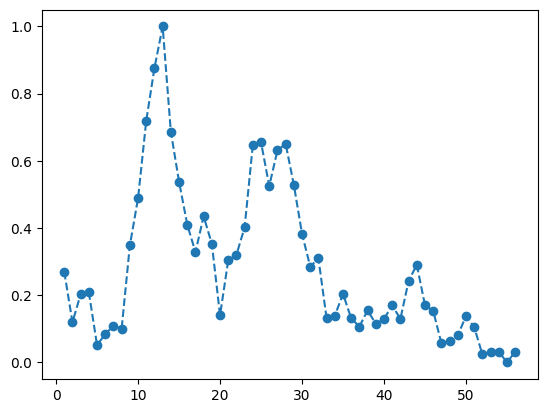

In [24]:
y_train_final.shape
plt.plot(np.linspace(1, len(y_train_final), len(y_train_final)), y_train_final[:,0], '--o')

### Prepare to use LSTM Model

In [25]:
# model parameters
lookback             = 6
hidden_size          = 32
num_layers           = 2
dropout              = 0.2
learning_rate        = 0.001
epochs               = 300
weight_decay         = 1e-5

In [26]:
input_layers = X_train_final.shape[-1]
print(f"LSTM will have {input_layers} input layers")

LSTM will have 9 input layers


In [27]:
# create the model
model_lstm = LSTM(input_size=input_layers, hidden_size=hidden_size, dropout=dropout, num_layers=num_layers)

In [28]:
# create the loss function and optimizer
criterion = RMSELoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=learning_rate, weight_decay=weight_decay )
# optimizer = optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [29]:
trainer2 = TrainerNewNew(model = model_lstm, criterion = criterion, optimizer = optimizer, scaler = scaler_y)
h, y_train_pred, y_train_true = trainer2.train(X_train=X_train_final, y_train = y_train_final, 
              X_test= X_test_final, y_test= y_test_final, epochs=epochs)
y_test_pred, y_test_true = trainer2.evaluate(X_test=X_test_final, y_test = y_test_final)


Epoch 1/300 - Training Loss 0.3341, Testing Loss 0.0805
Epoch 11/300 - Training Loss 0.2412, Testing Loss 0.1612
Epoch 21/300 - Training Loss 0.2363, Testing Loss 0.2532
Epoch 31/300 - Training Loss 0.2278, Testing Loss 0.1902
Epoch 41/300 - Training Loss 0.2252, Testing Loss 0.1994
Epoch 51/300 - Training Loss 0.2218, Testing Loss 0.2160
Epoch 61/300 - Training Loss 0.2155, Testing Loss 0.1934
Epoch 71/300 - Training Loss 0.1946, Testing Loss 0.1640
Epoch 81/300 - Training Loss 0.1688, Testing Loss 0.0758
Epoch 91/300 - Training Loss 0.1542, Testing Loss 0.0887
Epoch 101/300 - Training Loss 0.1377, Testing Loss 0.0643
Epoch 111/300 - Training Loss 0.1262, Testing Loss 0.0637
Epoch 121/300 - Training Loss 0.1083, Testing Loss 0.0569
Epoch 131/300 - Training Loss 0.0886, Testing Loss 0.0566
Epoch 141/300 - Training Loss 0.0787, Testing Loss 0.0547
Epoch 151/300 - Training Loss 0.0801, Testing Loss 0.0548
Epoch 161/300 - Training Loss 0.0734, Testing Loss 0.0543
Epoch 171/300 - Training 

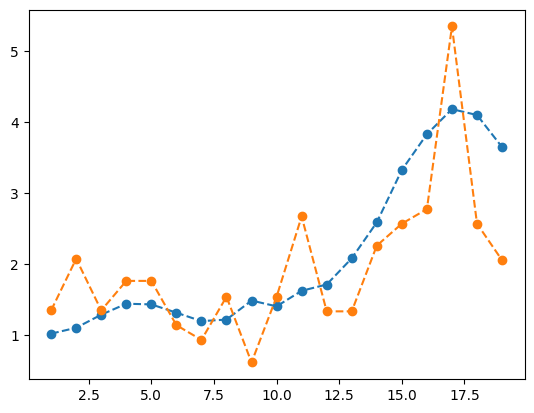

In [30]:
plt.plot(np.linspace(1, len(y_test_pred), len(y_test_pred)), y_test_pred, '--o')
plt.plot(np.linspace(1, len(y_test_true), len(y_test_true)), y_test_true, '--o')

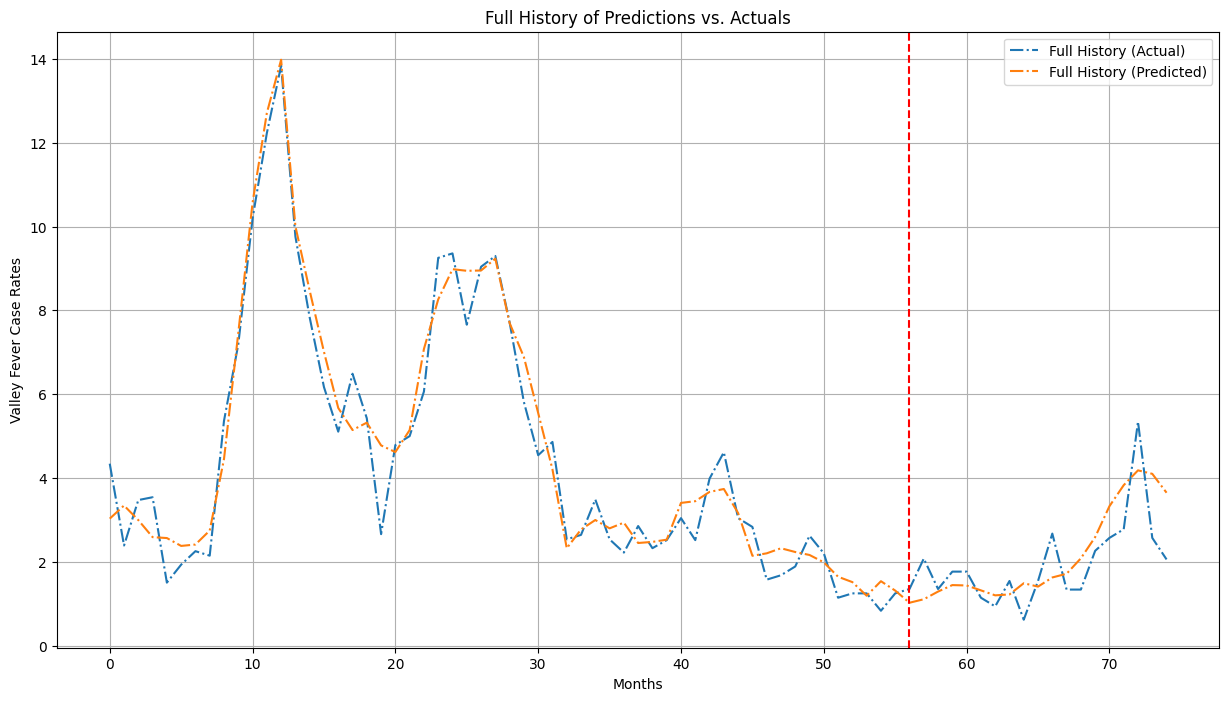

In [31]:
# Concatenate the training and testing predictions and true values
full_preds = np.concatenate((y_train_pred, y_test_pred))
full_true = np.concatenate((y_train_true, y_test_true))

# Create the full history plot
plt.figure(figsize=(15, 8))
plt.plot(full_true, label='Full History (Actual)', linestyle='-.')
plt.plot(full_preds, label='Full History (Predicted)', linestyle='-.')
plt.axvline(x=split_idx, color='r', linestyle='--')
plt.title("Full History of Predictions vs. Actuals")
plt.xlabel("Months")
plt.ylabel("Valley Fever Case Rates")
plt.legend()
plt.grid(True)
plt.show()